In [66]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (10, 10)
import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
import pymc3 as pm

In [67]:
#Read in data from data directory
input_df = pd.read_csv('./data/punt_returns.csv',header=0)

#Select useful numeric features to model our target variable kickReturnYardage
features = ['quarter','yardsToGo','preSnapHomeScore','preSnapVisitorScore','snapTime','hangTime',
            'operationTime','kickLength','penaltyYards','s','a','dis','o','dir','distance_returner_gunner1',
            'distance_returner_gunner2','y_football_rescaled','kickReturnYardage']

#Filter input_df to only include relevant features
df = input_df[features]

In [68]:
df.describe()

,quarter,yardsToGo,preSnapHomeScore,preSnapVisitorScore,snapTime,hangTime,operationTime,kickLength,penaltyYards,s,a,dis,o,dir,distance_returner_gunner1,distance_returner_gunner2,y_football_rescaled,kickReturnYardage
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2324.000000,2325.000000,2325.000000,410.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2289.000000
mean,2.407742,9.837849,10.537204,9.854194,0.858959,4.324811,2.135191,49.457204,5.229268,2.600856,2.498378,0.262335,190.420619,177.804495,16.134860,15.866172,58.646955,8.677588
std,1.112722,5.990450,9.472990,9.423247,0.063673,0.453489,0.116749,7.008999,8.552791,1.478856,1.244845,0.148993,94.218842,105.043187,9.841988,9.624955,25.256801,10.566846
min,1.000000,1.000000,0.000000,0.000000,0.590000,2.430000,1.660000,5.000000,-15.000000,0.030000,0.080000,0.000000,0.760000,0.110000,0.344819,0.332415,-31.520000,-13.000000
25%,1.000000,5.000000,3.000000,0.000000,0.820000,4.080000,2.070000,45.000000,5.000000,1.480000,1.550000,0.150000,97.320000,89.030000,8.668800,8.680973,39.440000,2.000000
50%,2.000000,9.000000,9.000000,7.000000,0.860000,4.400000,2.140000,50.000000,10.000000,2.390000,2.370000,0.240000,229.490000,176.180000,14.464415,14.288631,59.920000,7.000000
75%,3.000000,14.000000,17.000000,16.000000,0.900000,4.650000,2.200000,54.000000,10.000000,3.480000,3.330000,0.350000,276.890000,269.410000,21.653605,21.139584,79.360000,12.000000
max,5.000000,46.000000,54.000000,51.000000,1.190000,5.430000,4.920000,79.000000,15.000000,8.210000,7.990000,0.830000,359.640000,359.970000,58.135060,70.356420,100.000000,99.000000


In [69]:
import math

def computeTicks (x, step = 5):
    """
    Computes domain with given step encompassing series x
    @ params
    x    - Required - A list-like object of integers or floats
    step - Optional - Tick frequency
    """
    xMax, xMin = math.ceil(max(x)), math.floor(min(x))
    dMax, dMin = xMax + abs((xMax % step) - step) + (step if (xMax % step != 0) else 0), xMin - abs((xMin % step))
    return range(dMin, dMax, step)

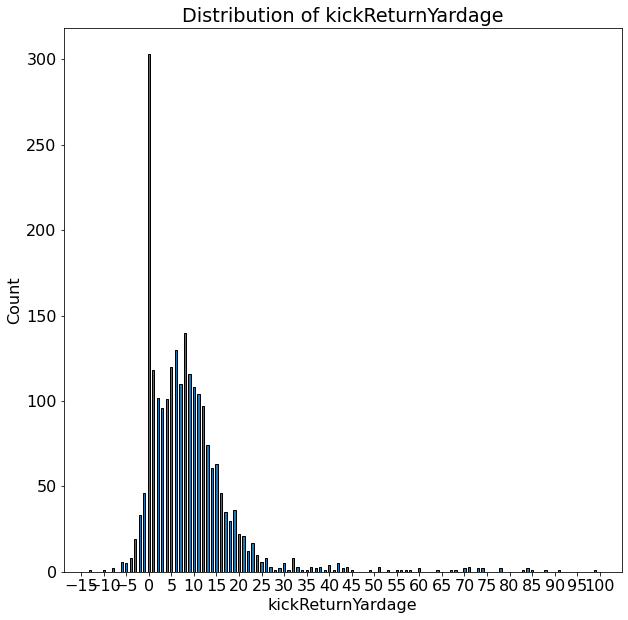

In [70]:
# Bar plot of grades
plt.bar(df['kickReturnYardage'].value_counts().index, 
        df['kickReturnYardage'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 0.5)
plt.xlabel('kickReturnYardage'); plt.ylabel('Count'); plt.title('Distribution of kickReturnYardage');
plt.xticks(computeTicks(df['kickReturnYardage'].value_counts().index));

In [71]:
correlation_result = df.corr()['kickReturnYardage'].sort_values()
correlation_list =list(zip(correlation_result.index, correlation_result.values))
correlation_list

[('penaltyYards', -0.15063499894874638),
 ('s', -0.03224024279242861),
 ('dis', -0.03068830054110115),
 ('a', -0.02220479386384686),
 ('operationTime', -0.016331432853747475),
 ('preSnapHomeScore', -0.010146744766807445),
 ('preSnapVisitorScore', -0.0071798985522723655),
 ('hangTime', -0.0028989218521071414),
 ('quarter', -0.001059549352031851),
 ('o', 0.0009776022654363718),
 ('snapTime', 0.004766921512825578),
 ('dir', 0.006040256340115891),
 ('yardsToGo', 0.021358244641256987),
 ('y_football_rescaled', 0.050836477408908586),
 ('distance_returner_gunner2', 0.13800398916512716),
 ('distance_returner_gunner1', 0.17930198672417647),
 ('kickLength', 0.1851672036440199),
 ('kickReturnYardage', 1.0)]

In [72]:
def feature_selection_train_test(dataframe, threshold):
    """[Finds the most correlated variables with the 
    kickReturnYardage variable and returns training and testing datasets]

    Args:
        dataframe ([type]): [Input dataframe for nhl data]
        threshold ([type]): [Threshold value used to filter the correlated features]
        
    """    
    dataframe['penaltyYards'] = dataframe['penaltyYards'].replace(np.NaN, 0)
    dataframe['kickReturnYardage'] = dataframe['kickReturnYardage'].replace(np.NaN, 0)
    # Targets are kick return yardage
    labels = dataframe['kickReturnYardage']
    
    #List of columns and their correlation value with the target label
    correlation_result = dataframe.corr().abs()['kickReturnYardage'].sort_values(ascending=False)
    correlation_list =list(zip(correlation_result.index, correlation_result.values)) 
    # Maintain the top 6 most correlation features with Grade
    most_correlated = [feature for (feature, value) in correlation_list if value > threshold]
    dataframe = dataframe[most_correlated]
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(dataframe, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test

In [73]:
X_train, X_test, y_train, y_test = feature_selection_train_test(df, 0.02)

c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


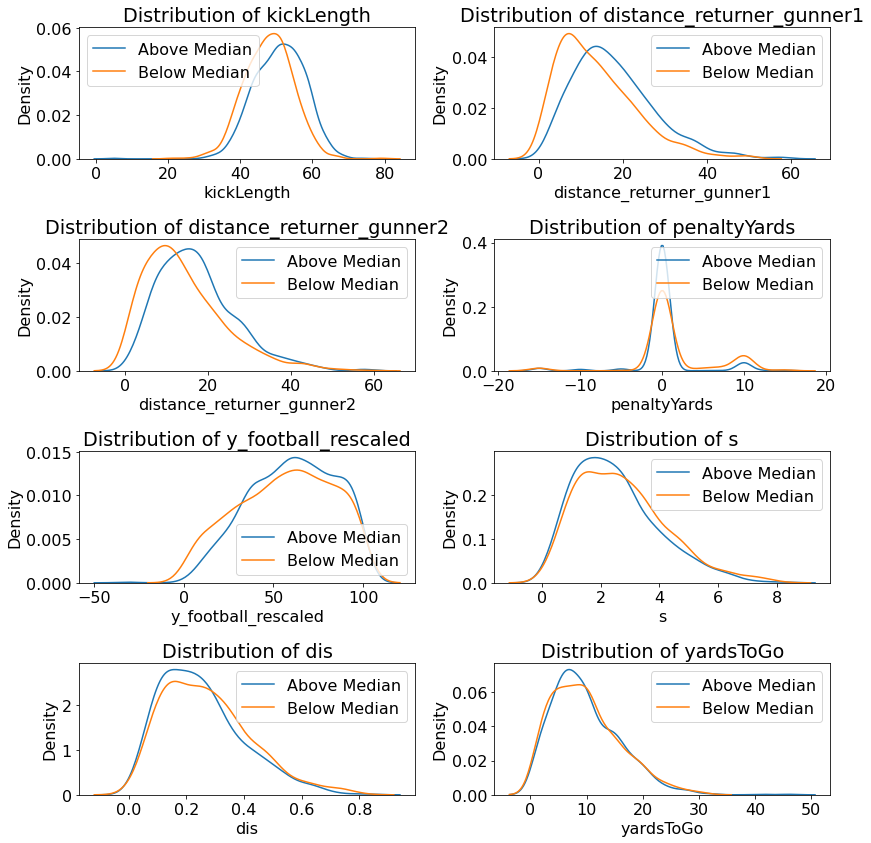

In [74]:
# X_train is our training data, we will make a copy for plotting
X_plot = X_train.copy()
# Compare grades to the median
X_plot['above_or_below_median'] = (X_plot['kickReturnYardage'] >= np.median(np.array(df['kickReturnYardage'])))
X_plot['above_or_below_median'] = X_plot['above_or_below_median'].replace({True: 'Above', 
                                          False: 'Below'})
# Plot all variables in a loop
plt.figure(figsize=(12, 12))
for i, col in enumerate(X_plot.columns[1:-1]):
    plt.subplot(4, 2, i + 1)
    subset_above = X_plot[X_plot['above_or_below_median'] == 'Above']
    subset_below = X_plot[X_plot['above_or_below_median'] == 'Below']
    sns.kdeplot(subset_above[col], label = 'Above Median')
    sns.kdeplot(subset_below[col], label = 'Below Median')
    plt.legend()
    plt.title('Distribution of %s' % col)
    
plt.tight_layout()

In [77]:

def train_ml_models(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series):
    """[Take input train and test datasets to test various machine learning models in order
    to develop baseline models]

    Args:
        X_train (pd.DataFrame): [Input training dataframe]
        X_test (pd.DataFrame): [Input test dataframe]
        y_train (pd.Series): [Label training data for kickReturnYardage]
        y_test (pd.Series): [Label test data for kickReturnYardage]
    """
    # Names of models
    model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosted', 'baseline']
    X_train = X_train.drop(columns='kickReturnYardage')
    X_test = X_test.drop(columns='kickReturnYardage')
    
    # Instantiate the models
    models = [LinearRegression(),RandomForestRegressor(n_estimators=50),GradientBoostingRegressor(n_estimators=20)]
    
    # Dataframe for results
    results = pd.DataFrame(columns=['MAE', 'RMSE'], index = model_names)
    
    #Train each model and then retrieve predictions to get validation scores
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_names[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [81]:
train_ml_models_results = train_ml_models(X_train, X_test, y_train, y_test)
train_ml_models_results

,MAE,RMSE
Linear Regression,6.175323,10.451152
Random Forest,6.396804,10.504077
Gradient Boosted,6.108968,10.351924
baseline,6.551546,11.023795


In [15]:
#Create formula used by GLM formulation for Bayesian Regression Model
formula = 'kickReturnYardage ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'kickReturnYardage ~ kickLength + distance_returner_gunner1 + distance_returner_gunner2 + penaltyYards + y_football_rescaled + s + dis + yardsToGo'

In [33]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be assumed to be normal
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform mcmc sampling inference for the posterior
    # Have a choice of samplers
    step = pm.Metropolis()
    trace = pm.sample(draws=2000,step=step, chains = 2, tune = 500,cores=4)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [yardsToGo]
>Metropolis: [dis]
>Metropolis: [s]
>Metropolis: [y_football_rescaled]
>Metropolis: [penaltyYards]
>Metropolis: [distance_returner_gunner2]
>Metropolis: [distance_returner_gunner1]
>Metropolis: [kickLength]
>Metropolis: [Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2002 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'kickLength'}>,
        <AxesSubplot:title={'center':'kickLength'}>],
       [<AxesSubplot:title={'center':'distance_returner_gunner1'}>,
        <AxesSubplot:title={'center':'distance_returner_gunner1'}>],
       [<AxesSubplot:title={'center':'distance_returner_gunner2'}>,
        <AxesSubplot:title={'center':'distance_returner_gunner2'}>],
       [<AxesSubplot:title={'center':'penaltyYards'}>,
        <AxesSubplot:title={'center':'penaltyYards'}>],
       [<AxesSubplot:title={'center':'y_football_rescaled'}>,
        <AxesSubplot:title={'center':'y_football_rescaled'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'dis'}>,
        <AxesSubplot:title={'center':'dis'}>],
       [<AxesSubplot:title={'center':'yardsToGo'}>,
        <AxesSubplot:title={'center':'yardsT

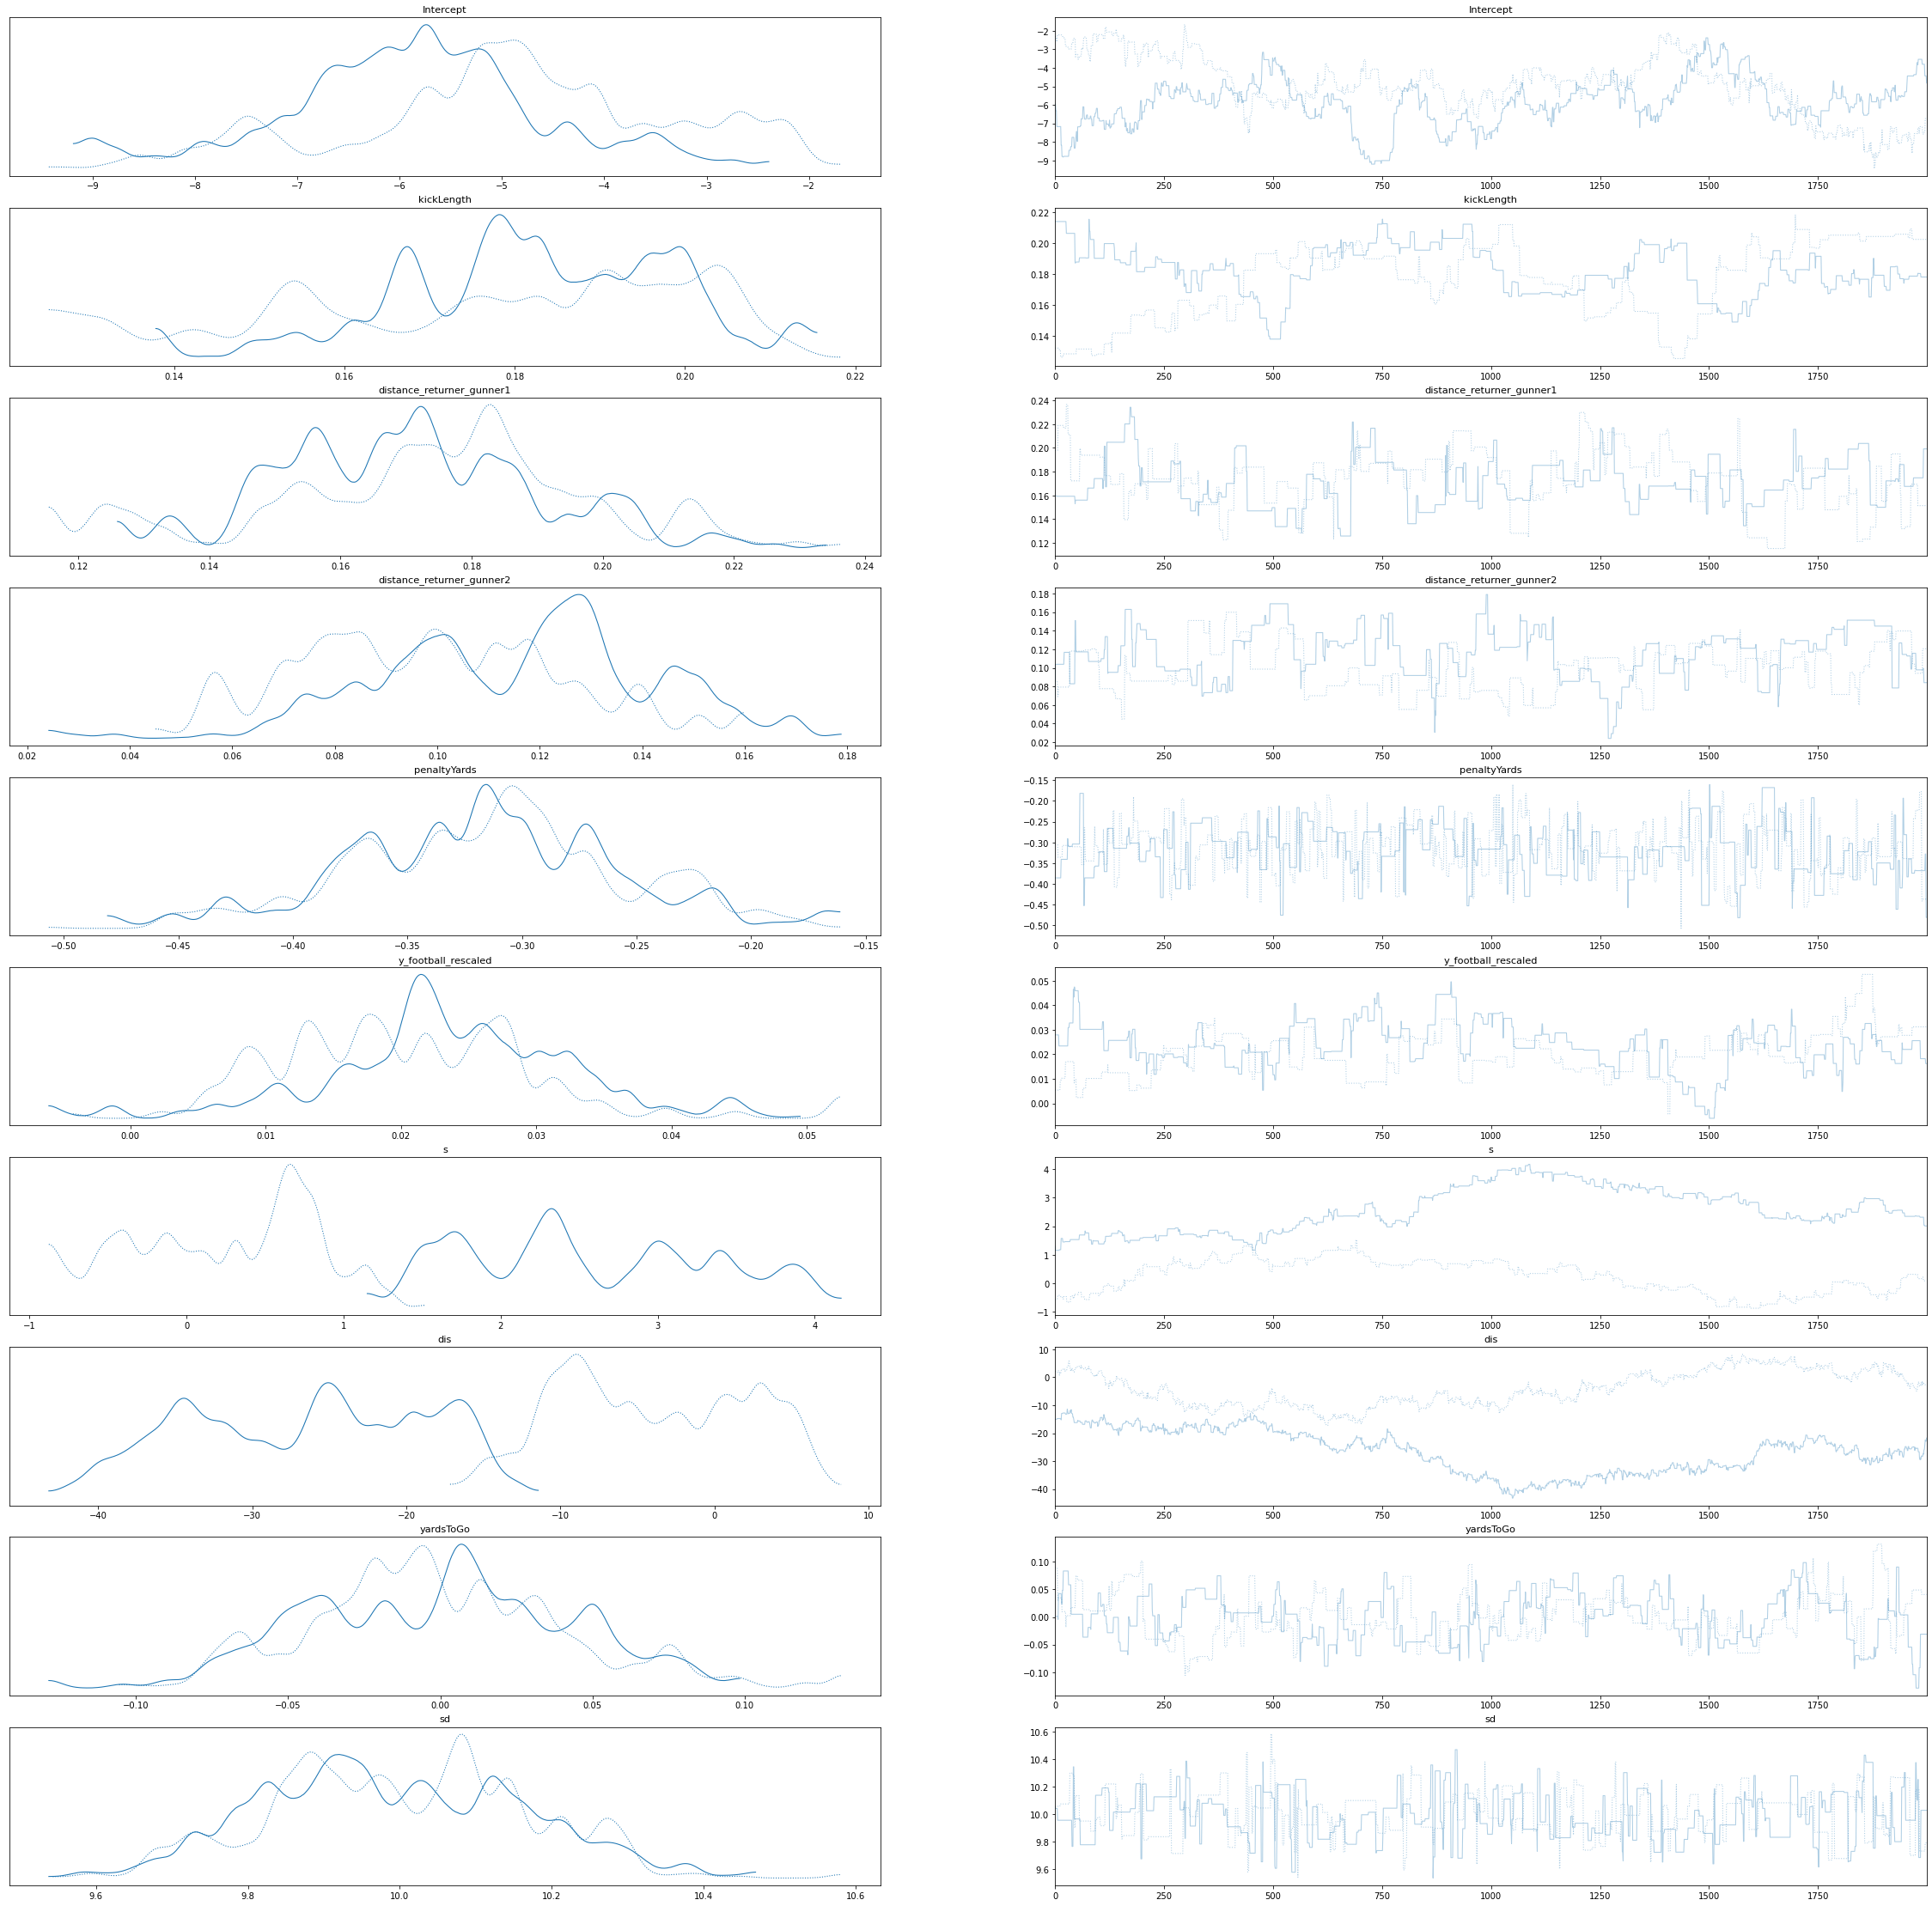

In [57]:
pm.traceplot(trace, figsize=(30,30))

c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

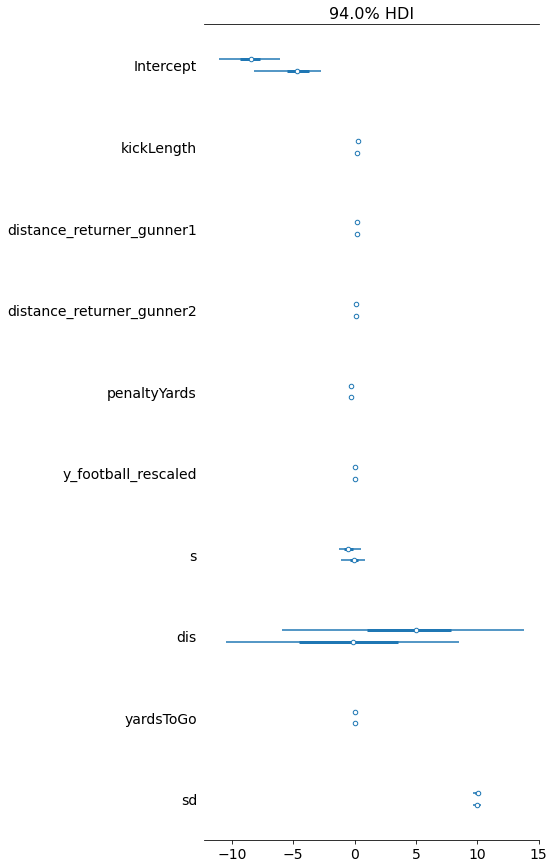

In [31]:
pm.forestplot(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'kickLength'}>,
        <AxesSubplot:title={'center':'distance_returner_gunner1'}>],
       [<AxesSubplot:title={'center':'distance_returner_gunner2'}>,
        <AxesSubplot:title={'center':'penaltyYards'}>,
        <AxesSubplot:title={'center':'y_football_rescaled'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'dis'}>,
        <AxesSubplot:title={'center':'yardsToGo'}>],
       [<AxesSubplot:title={'center':'sd'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

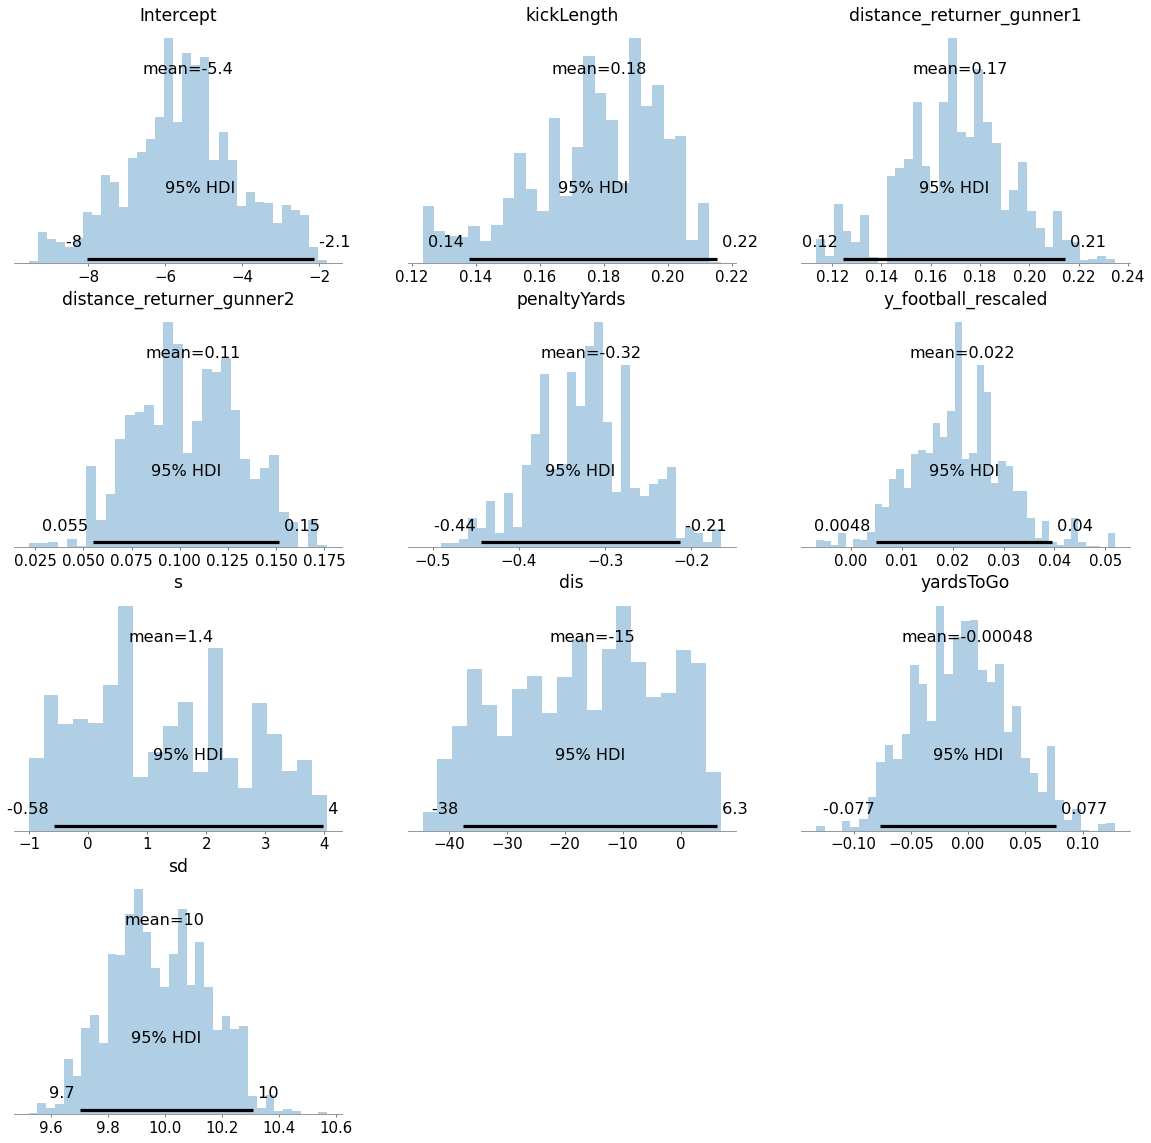

In [40]:
pm.plot_posterior(trace, figsize = (20, 20), kind='hist',textsize=15,hdi_prob=0.95)

In [84]:
pm.summary(trace, hdi_prob=0.95)

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\mjpearl\Desktop\omsa\ISYE-6420-OAN\env_ISYE6420\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-5.400,1.520,-8.044,-2.144,0.472,0.344,10.0,23.0,1.16
kickLength,0.179,0.021,0.138,0.216,0.005,0.004,15.0,38.0,1.09
distance_returner_gunner1,0.172,0.022,0.124,0.214,0.003,0.002,50.0,79.0,1.05
distance_returner_gunner2,0.107,0.027,0.055,0.151,0.005,0.003,35.0,81.0,1.08
penaltyYards,-0.316,0.059,-0.444,-0.213,0.003,0.002,309.0,370.0,1.01
y_football_rescaled,0.022,0.009,0.005,0.040,0.002,0.001,25.0,76.0,1.08
s,1.406,1.350,-0.577,3.974,0.886,0.728,3.0,13.0,2.23
dis,-15.262,13.233,-37.511,6.299,8.669,7.120,3.0,12.0,2.27
yardsToGo,-0.000,0.042,-0.077,0.077,0.005,0.004,68.0,116.0,1.01
sd,9.996,0.168,9.702,10.308,0.011,0.007,264.0,229.0,1.00


In [85]:

def evaluate_bayesian_model(trace, X_test, y_test, model_results):
    """[Evalute the bayesian model rmse and mawe]

    Args:
        trace ([type]): [Trace pymc.sample object containing model result]
        X_test ([type]): [Test dataset X]
        y_test ([type]): [Test label Series]
        model_results ([type]): [Results of the summary statistics for model performance]

    """    
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    var_weights = pd.DataFrame(var_dict)
    var_means = var_weights.mean(axis=0)
    X_test['Intercept'] = 1
    
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))

    
    # Add the results to the comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    return model_results

In [87]:
final_model_results = evaluate_bayesian_model(normal_trace, X_test, y_test, train_ml_models_results)
final_model_results

,MAE,RMSE
Linear Regression,6.175323,10.451152
Random Forest,6.396804,10.504077
Gradient Boosted,6.108968,10.351924
baseline,6.551546,11.023795
Bayesian LR,6.1504,10.444441
